Based on a notebook by Stephen Taylor

This notebook uses a very basic population synthesis model to test out the analytical relations found in Lamb & Taylor 2024

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import G, c
from astropy import units as u
from scipy.stats import rv_histogram, skew
from scipy.stats import kurtosis as kurt_sp
from matplotlib.lines import Line2D

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
cd /Users/lambwg/Documents/Vanderbilt/Research/pop_synth//

/Users/lambwg/Documents/Vanderbilt/Research/pop_synth


In [4]:
# Stephen Taylor's default matplotlib settings
rc_params = {"axes.labelsize": 10, "lines.markersize": 4, #"backend": "pdf", 
             "font.size": 10, "xtick.top": True, "ytick.right": True,
             "xtick.major.size": 6, "xtick.minor.size": 3,
             "ytick.major.size": 6, "ytick.minor.size": 3,
             "xtick.major.width": 0.5, "ytick.major.width": 0.5,
             "xtick.minor.width": 0.5, "ytick.minor.width": 0.5,
             "lines.markeredgewidth": 1, "axes.linewidth": 1.2,
             "legend.fontsize": 7, "xtick.labelsize": 10,
             "xtick.direction": "in", "xtick.minor.visible": True,
             "xtick.major.top": True, "xtick.minor.top": True,
             "ytick.labelsize": 10, "ytick.direction": "in",
             "ytick.minor.visible": True, "ytick.major.right": True,
             "ytick.minor.right": True, "savefig.dpi": 400,
             "path.simplify": True, "font.family": "serif",
             "font.serif": "Times", "text.usetex": True,
             "figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(rc_params)

In [5]:
# constants
fyr = 1 / 365.25 / 86400.0
G = 4.517103 * 10**-48  # Mpc3 / Msun s2
c = 9.7156119 * 10**-15  # Mpc / s

# Variation relations
This is a very basic population synthesis model that creates a distribution of binaries as a function of emitted GW frequency. For circular binaries that evolve purely due to GW emission, we expect that $\mathrm{d}t/\mathrm{d}f \propto f^{-11/3}$. Therefore, we sample from this distribution to get our binaries, bin them, and add them in quadrature

In [6]:
## Make a binary distribution function going as f^{-11/3}
A = 1e-22  # arbitrary normalisation
f = np.linspace(1e-9,1e-7,int(1e6))  # frequency grid
fbmid = 0.5 * (f[1:] + f[:-1])  # middle of grid cells
Nf = A * fbmid**(-11./3.)  # dt / df for GW emission

Text(0, 0.5, 'Number of sources')

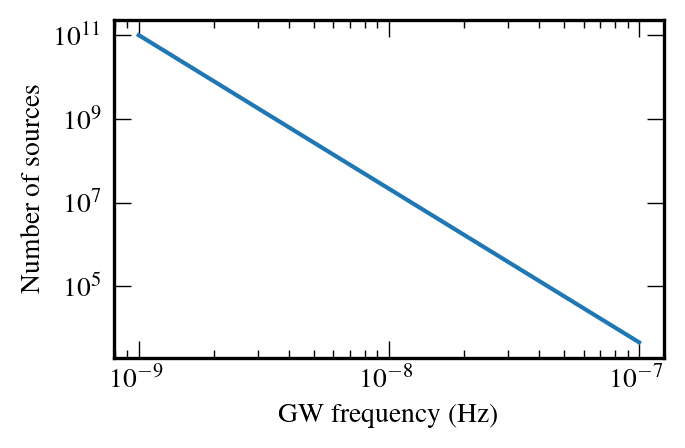

In [7]:
plt.loglog(fbmid, Nf)
plt.xlabel('GW frequency (Hz)')
plt.ylabel('Number of sources')

In [8]:
# we need to sample the binary distribution. Use scipy's rv_histogram
test = ss.rv_histogram((Nf,f)) # make a scipy.stats object

In [9]:
## Create structures for Omega_gw across realizations
Tspan = 20. * 86400 * 365.24
bins = (np.arange(1, 102) - 0.5) / Tspan  # 20-year bins
bmid = 0.5 * (bins[1:] + bins[:-1])  # bin mids

omega = np.zeros((bmid.shape[0], int(1e4))) # frequency-bins x realizations

In [10]:
# Make Omega_gw spectrum for each realization
for jj in range(omega.shape[1]):

    freqs = test.rvs(size=int(1e4))  # frequencies of 10000 sampled binaries
    mask = np.digitize(freqs, bins) - 1  # bin the binaries by frequency

    # Background spectrum is sum of squared strain amplitudes.
    # Power of 10/3 from h^2 and conversion from h_c^2(f) to Omega(f),
    # then binned by frequency
    for ii, bin in enumerate(bmid):
        omega[ii, jj] = np.sum(freqs[mask==ii]**(10/3) *
                               freqs[mask==ii]/Tspan)

The variance of the following quantities can be deduced analytically.

## $\Omega_\mathrm{GW}(f)$

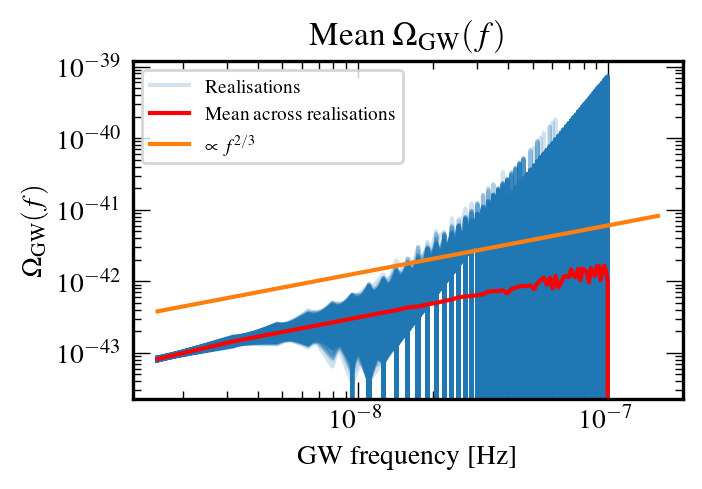

In [11]:
# Plot omega for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj], alpha=0.2, color='C0')
plt.loglog(bmid, np.mean(omega, axis=1), color='r')
plt.loglog(bmid, 2.8e-42 * (bmid/fyr)**(2/3), color='C1')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h2, h3])

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$');
plt.title(r'Mean $\Omega_\mathrm{GW}(f)$');

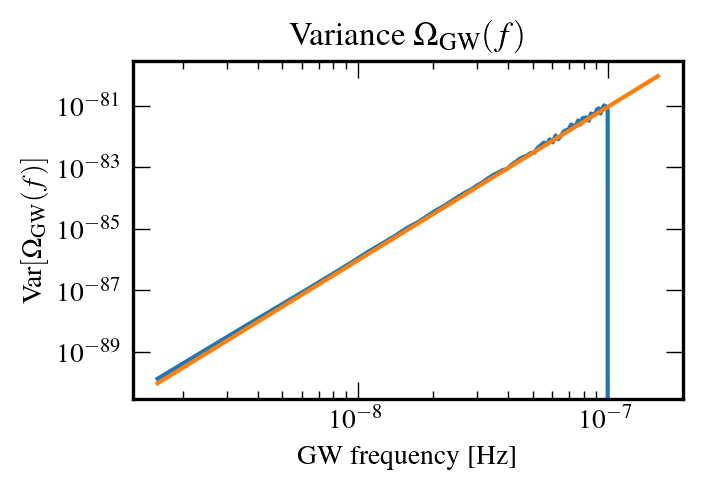

In [12]:
## Variance of Omega_gw
plt.loglog(bmid, np.var(omega, axis=1), label='Variance over realisations')
plt.loglog(bmid, 3e-84*(bmid/fyr)**(5.), label=r'$\propto f^5$')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'Var$[\Omega_\mathrm{GW}(f)]$');
plt.title(r'Variance $\Omega_\mathrm{GW}(f)$');

## $h_\mathrm{c}^2(f)$

/Users/lambwg/Applications/miniconda3/envs/ceffyl/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/lambwg/Applications/miniconda3/envs/ceffyl/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lambwg/Applications/miniconda3/envs/ceffyl/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


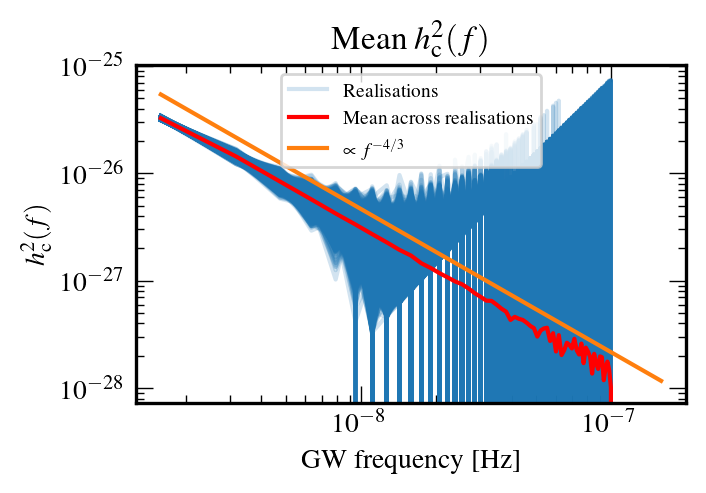

In [16]:
# Plot h_c^2(f) for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**2, alpha=0.2, color='C0')
plt.loglog(bmid, 1e-27 * (bmid/fyr)**(-4/3.), color='C1')
plt.loglog(bmid, np.mean(omega/bmid[:, None]**2, axis=1), color='r')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{-4/3}$')
plt.legend(handles=[h1, h2, h3])

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$h_\mathrm{c}^2(f)$');
plt.title(r'Mean $h^2_\mathrm{c}(f)$');

Text(0.5, 1.0, 'Variance $h_\\mathrm{c}(f)^2$')

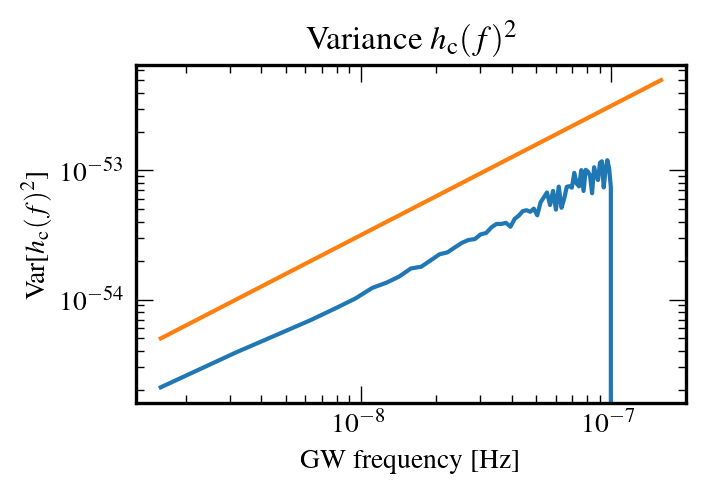

In [17]:
# variance of hc^2
plt.loglog(bmid, np.var(omega/bmid[:, None]**2, axis=1))
plt.loglog(bmid, 1.e-53*(bmid/fyr))
plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var[$h_\mathrm{c}(f)^2$]')
plt.title(r'Variance $h_\mathrm{c}(f)^2$')

## $S_{\delta t}(f)$

Text(0.5, 1.0, 'Mean $S_{\\delta t}(f)$')

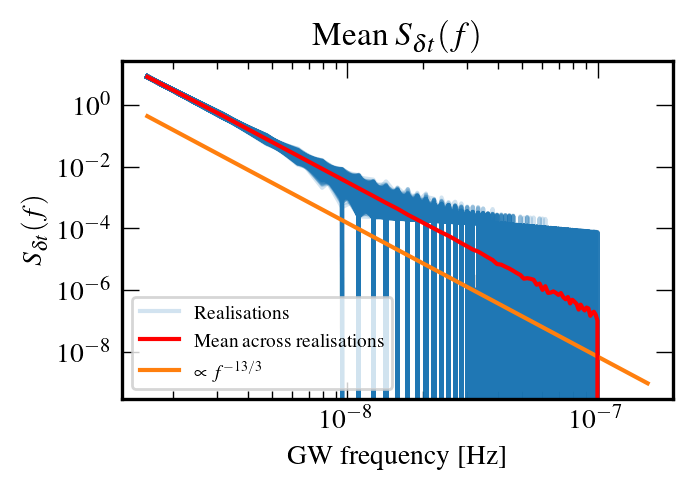

In [21]:
# Plot S(f) for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**5, alpha=0.2, color='C0')
plt.loglog(bmid, 1e-6 * (bmid/fyr)**(-13/3.), color='C1')
plt.loglog(bmid, np.mean(omega/bmid[:, None]**5, axis=1), color='r')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{-13/3}$')
plt.legend(handles=[h1, h2, h3], loc='lower left')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$S_{\delta t}(f)$');
plt.title(r'Mean $S_{\delta t}(f)$')

Text(0.5, 1.0, 'Variance $S_{\\delta t}(f)^2$')

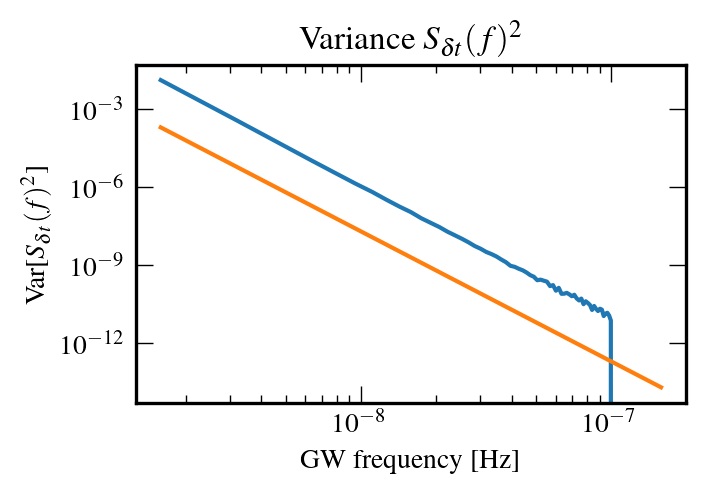

In [24]:
# variance of PSD
plt.loglog(bmid, np.var(omega/bmid[:, None]**5, axis=1))
plt.loglog(bmid, 2e-48*bmid**(-5.))
plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var[$S_{\delta t}(f)^2$]')
plt.title(r'Variance $S_{\delta t}(f)^2$')

# General $dt/df$...

For binaries that also interact with their environments, their frequency evolution is faster, and $\lambda\neq-11/3$.

Let $\frac{dt}{df} \propto f^\lambda$

For stellar scattering, $\lambda = -7/3$

In [26]:
## Make a binary distribution function going as f^lambda
A = 1e-22  # arbitrary
f = np.linspace(1e-9, 1e-7, int(1e6))  # frequncy grid
fbmid = 0.5 * (f[1:] + f[:-1])  # middle of grid cells

lamb_da = -7/3  # stellar scattering
Nf = A * fbmid**lamb_da  # dt / df for GW emission

Text(0, 0.5, 'Number of sources')

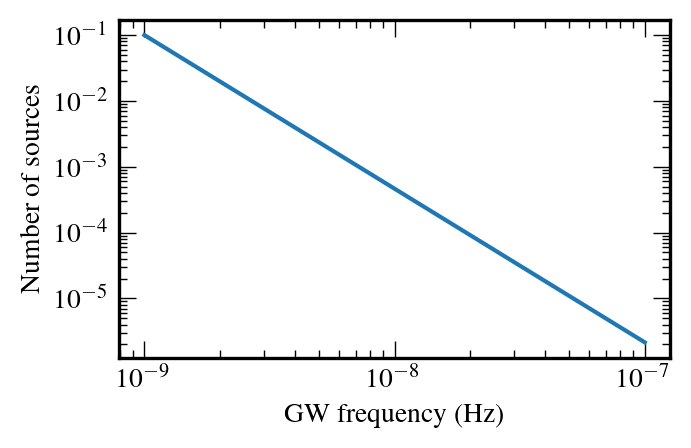

In [27]:
plt.loglog(fbmid, Nf)
plt.xlabel(r'GW frequency (Hz)')
plt.ylabel(r'Number of sources')

In [28]:
# we need to sample the binary distribution. Use scipy's rv_histogram
test = ss.rv_histogram((Nf,f)) # make a scipy.stats object

In [29]:
## Create structures for Omega_gw across realizations
Tspan = 20. * 86400 * 365.24
bins = (np.arange(1, 102) - 0.5) / Tspan  # 20-year bins
bmid = 0.5 * (bins[1:] + bins[:-1])  # bin mids

omega = np.zeros((bmid.shape[0], int(1e4))) # frequency-bins x realizations

In [30]:
# Make Omega_gw spectrum for each realization
for jj in range(omega.shape[1]):

    freqs = test.rvs(size=int(1e4))  # frequencies of 10000 sampled binaries
    mask = np.digitize(freqs, bins) - 1  # bin the binaries by frequency

    # Background spectrum is sum of squared strain amplitudes.
    # Power of 10/3 from h^2 and conversion from h_c^2(f) to Omega(f),
    # then binned by frequency
    for ii, bin in enumerate(bmid):
        omega[ii, jj] = np.sum(freqs[mask==ii]**(10/3) *
                               freqs[mask==ii]/Tspan)

## $\Omega_\mathrm{GW}(f)$

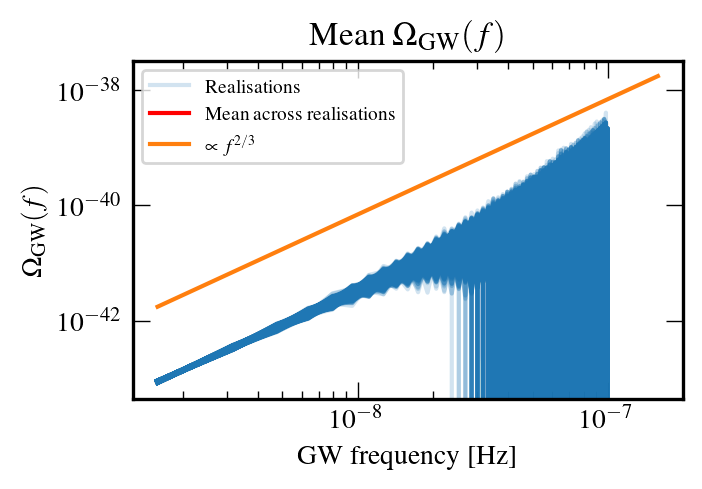

In [31]:
# Plot omega for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj], alpha=0.2, color='C0')
plt.loglog(bmid, 7e-40 * (bmid/fyr)**(lamb_da + 13/3), color='C1')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h2, h3])

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$');
plt.title(r'Mean $\Omega_\mathrm{GW}(f)$');

Text(0.5, 1.0, 'Variance $\\Omega_\\mathrm{GW}(f)$')

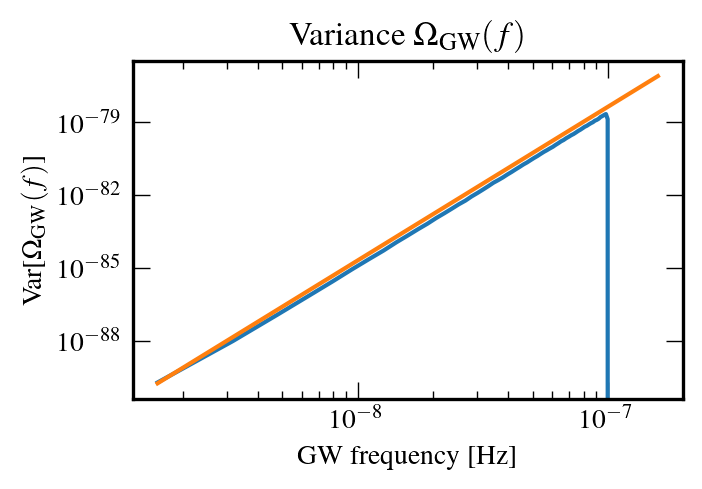

In [32]:
## Variance of Omega_gw
plt.loglog(bmid, np.var(omega, axis=1))
plt.loglog(bmid, 3e-82*(bmid/fyr)**(lamb_da + 26/3.))

plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var[$\Omega_\mathrm{GW}(f)$]')
plt.title(r'Variance $\Omega_\mathrm{GW}(f)$')

## $h_\mathrm{c}^2(f)$

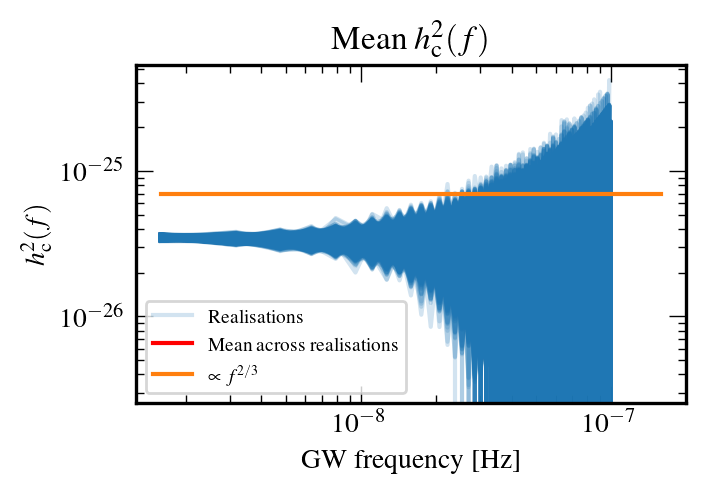

In [33]:
# Plot h_c^2 for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**2, alpha=0.2, color='C0')
plt.loglog(bmid, 7e-26 * (bmid/fyr)**(lamb_da + 7/3.), color='C1')

# legend handles and labels
h1 = Line2D([], [], alpha=0.2, color='C0', label='Realisations')
h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='C1', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h2, h3], loc='lower left')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$h_\mathrm{c}^2(f)$');
plt.title(r'Mean $h_\mathrm{c}^2(f)$');

Text(0.5, 1.0, 'Variance $h^2_\\mathrm{c}(f)$')

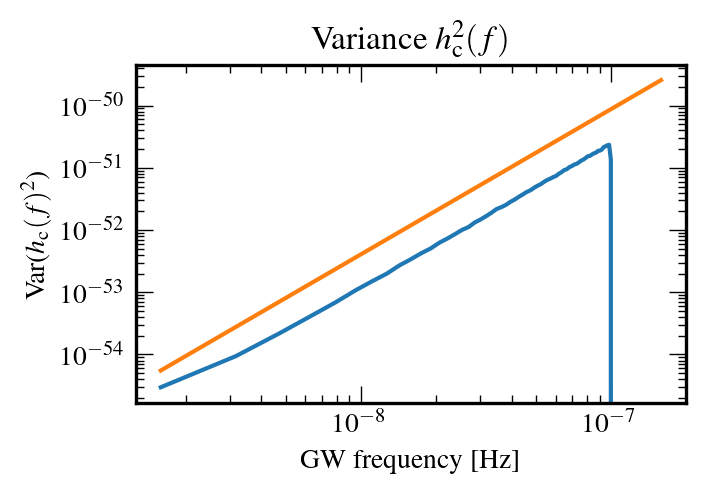

In [34]:
# variance of hc^2
plt.loglog(bmid, np.var(omega/bmid[:, None]**2, axis=1))
plt.loglog(bmid, 6.e-52*(bmid/fyr)**(lamb_da + 14/3))

plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var($h_\mathrm{c}(f)^2$)')
plt.title(r'Variance $h^2_\mathrm{c}(f)$')

## $S_{\delta t}(f)$

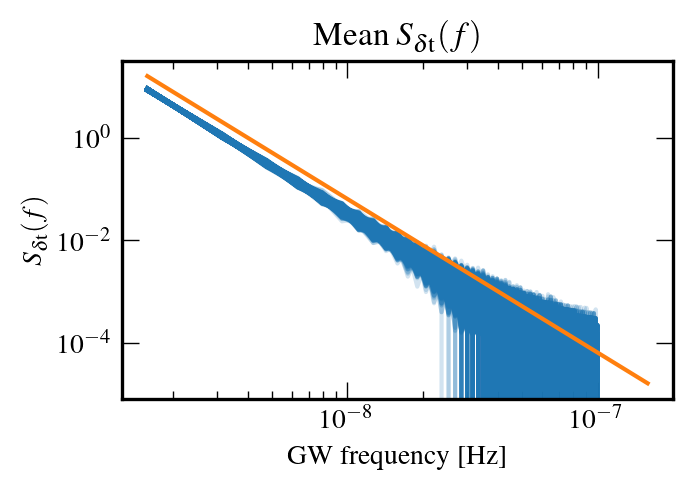

In [35]:
# Plot psd for all realizations
for jj in range(omega.shape[1]):
  plt.loglog(bmid, omega[:, jj]/bmid**5, alpha=0.2, color='C0')
plt.loglog(bmid, 2e-3 * (bmid/fyr)**(lamb_da-2/3.), color='C1')

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$S_\mathrm{\delta t}(f)$')
plt.title(r'Mean $S_\mathrm{\delta t}(f)$');

Text(0.5, 1.0, 'Variance $S_\\mathrm{\\delta t}(f)$')

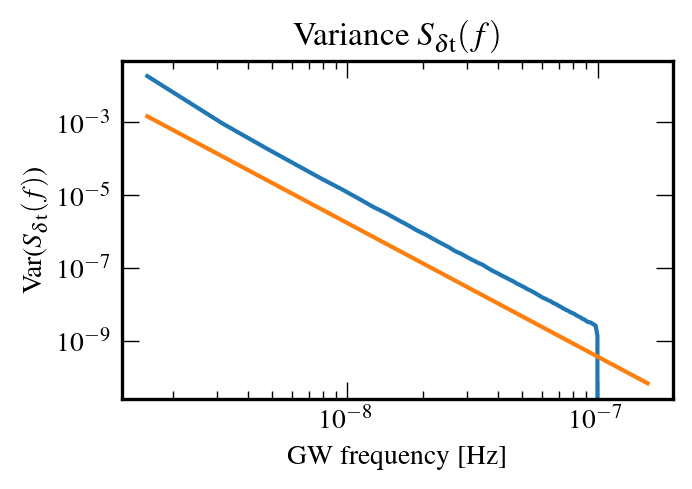

In [36]:
# variance of PSD
plt.loglog(bmid, np.var(omega/bmid[:, None]**5, axis=1))
plt.loglog(bmid, 2.5e-8*(bmid/fyr)**(lamb_da-4/3))

plt.xlabel('GW frequency [Hz]')
plt.ylabel(r'Var($S_\mathrm{\delta t}(f)$)')
plt.title(r'Variance $S_\mathrm{\delta t}(f)$')

These all work really well!!

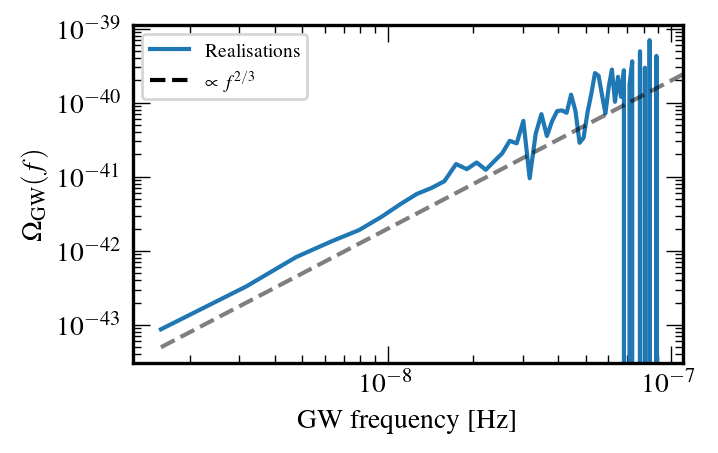

In [50]:
# Plot omega for all realizations
plt.loglog(bmid, omega[:, 100], alpha=1, color='C0')
plt.loglog(bmid, 2e-41 * (bmid/fyr)**(lamb_da + 13/3), color='k', ls='--', alpha=0.5)

# legend handles and labels
h1 = Line2D([], [], color='C0', label='Realisations')
#h2 = Line2D([], [], color='r', label='Mean across realisations')
h3 = Line2D([], [], color='k', ls='--', label=r'$\propto f^{2/3}$')
plt.legend(handles=[h1, h3])
plt.xlim(right=1.1e-7)

plt.xlabel('GW frequency [Hz]');
plt.ylabel(r'$\Omega_\mathrm{GW}(f)$');
#plt.title(r'Mean $\Omega_\mathrm{GW}(f)$');

# Synthesised idealised background

In [7]:
from scripts import pop_synth as ps

In [37]:
# define models
# MODEL 1
model1 = dict(alpha=1, log10_M_star=np.log10(3.2*10**7), beta=3, z0=3, n0_dot=2e-2)
model2 = dict(alpha=0.5, log10_M_star=np.log10(7.5*10**7), beta=2.5, z0=2.4, n0_dot=9.5e-3)
model3 = dict(alpha=0., log10_M_star=np.log10(1.8*10**8), beta=2, z0=1.8, n0_dot=1.5e-3)
model4 = dict(alpha=-0.5, log10_M_star=np.log10(4.2*10**8), beta=1.5, z0=1.1, n0_dot=9e-5)
model5 = dict(alpha=-1, log10_M_star=9., beta=1, z0=0.5, n0_dot=2e-6)
#model5 = dict(alpha=-1, log10_M_star=11., beta=1, z0=5, n0_dot=2.5e-11)

In [40]:
Tspan = 20 * 365.24 * 86400
f = np.arange(1, 31)/Tspan

#M = np.linspace(10**6, 10**11, 1000)
log10_M = np.linspace(6, 11, 1001)
z = np.linspace(0, 5, 101)

hc2_ideal = ps.gwb_ideal(f, log10_M, z, model4)

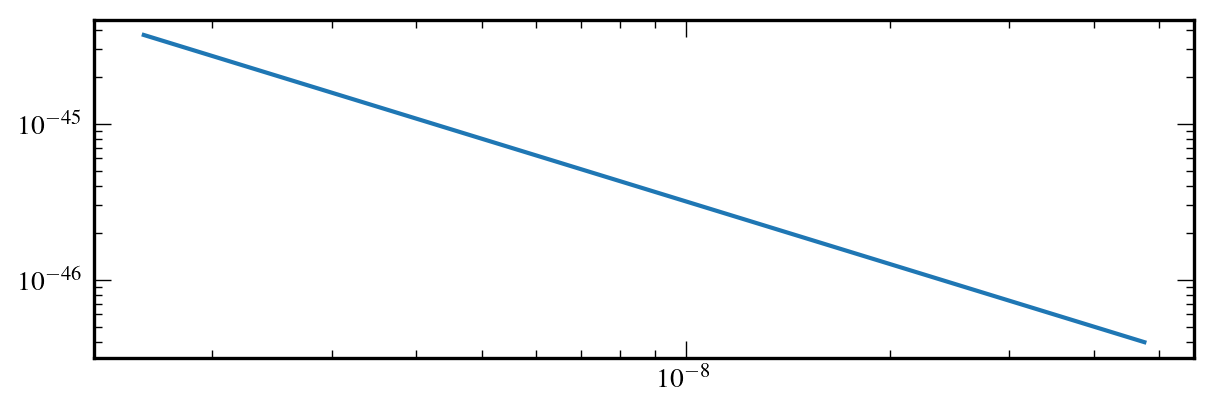

In [41]:
plt.plot(f, hc2_ideal)
plt.xscale('log', base=10)
plt.yscale('log', base=10)

# Poisson!

In [11]:
G = 4.517103 * 10**-48  # Mpc3 / Msun s2
c = 9.7156119 * 10**-15  # Mpc / s

In [12]:
Tspan = 20 * 365.24 * 86400
fbins = (np.arange(1, 32) - 0.5)/Tspan

In [13]:
z_bins = np.linspace(0, 5, 101)
#M_bins = np.linspace(10**6, 10**11, 1001)
log10_M_bins = np.linspace(6, 11, 1001)

#dM = M_bins[1] - M_bins[0]
#dz = z_bins[1] - z_bins[0]
#dlogf = np.log(fbins[1:]) - np.log(fbins[:-1])

f_mid = 0.5 * (fbins[1:] + fbins[:-1])
#M_mid = 0.5 * (M_bins[1:] + M_bins[:-1])
log10_M_mid = 0.5 * (log10_M_bins[1:] + log10_M_bins[:-1])
z_mid = 0.5 * (z_bins[1:] + z_bins[:-1])

In [14]:
N = ps.smbhb_number_per_cell(fbins, 10**log10_M_bins, z_bins, model4)

In [15]:
N.shape

(30, 1000, 100)

In [16]:
N.sum()

1045194662.0414128

In [17]:
model1

{'alpha': 1,
 'log10_M_star': 7.505149978319906,
 'beta': 3,
 'z0': 3,
 'n0_dot': 0.02}

In [ ]:
from tqdm import tqdm
nreal = 100000  # EXAMPLE NUMBER OF REALISATIONS - INCREASE FOR PRODUCTION
dlogf = (np.log(fbins[1:]) - np.log(fbins[:-1]))
models = [model1, model2, model3, model4, model5]
h2cf_synth = np.zeros((5, nreal, 30))

for ii in tqdm(range(5)):
    N = ps.smbhb_number_per_cell(fbins, 10**log10_M_bins, z_bins, models[ii])

    rng = np.random.default_rng()
    h2cf_synth[ii] = ps.pop_synth(N, fbins, 10*log10_M_mid, z_mid, n_real=nreal, seed=ii)

    np.save(f'./data/hc2f_10k_model{ii+1}', h2cf[ii])

Text(0.5, 0, 'GW Frequency (Hz)')

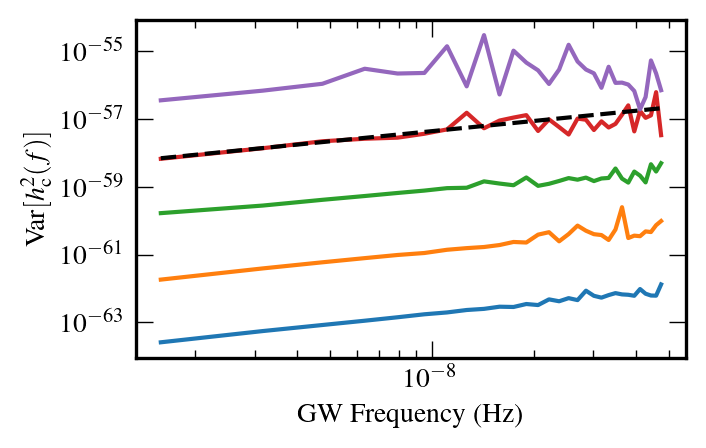

In [30]:
figsize_params = {"figure.figsize": [3.5503666805036667, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

var = np.var(h2cf_synth, axis=1)
[plt.plot(f_mid, var[ii], label=f'Model {ii+1}') for ii in range(5)]
plt.plot(f_mid, 1.4e-57 * (f_mid/fyr)**(1), c='k', ls='--', label=r'$f^1$')
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.ylabel(r'$\mathrm{Var}[h_\mathrm{c}^2(f)]$')
plt.xlabel(r'GW Frequency (Hz)')

Text(0.5, 0, 'GW Frequency (Hz)')

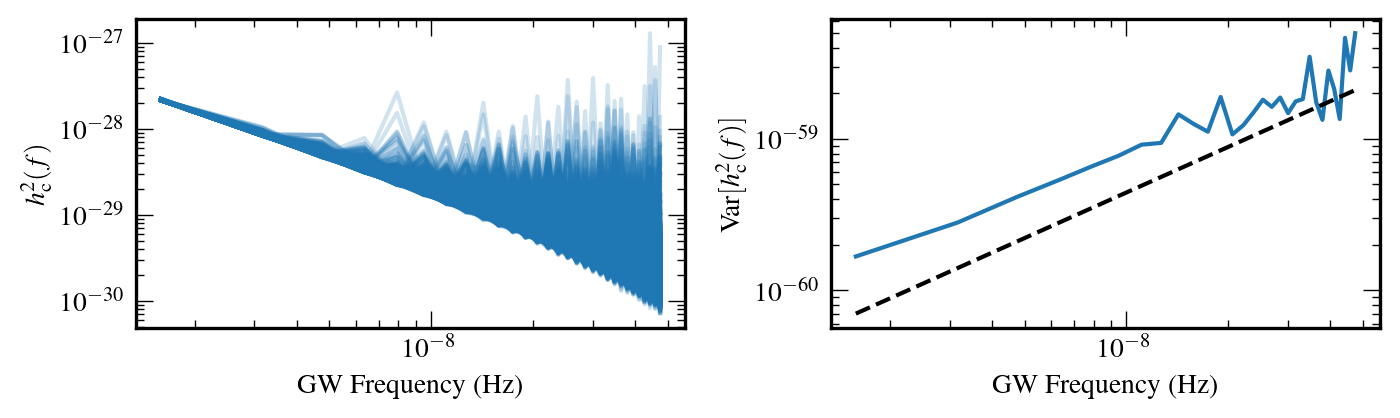

In [42]:
figsize_params = {"figure.figsize": [3.5503666805036667*2, 2.1942472810764047]}
plt.rcParams.update(figsize_params)

fig, axs = plt.subplots(ncols=2, tight_layout=True)
fyr = 1/(365.24*86400)

ax = axs[0]
ax.plot(f_mid, h2cf_synth[2, 0], c='C0', alpha=0.2, rasterized=True, label='GWB realisations')
[ax.plot(f_mid, h2cf_synth[2, ii], c='C0', alpha=0.2, rasterized=True) for ii in range(1, nreal)]

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$h_\mathrm{c}^2(f)$')
ax.set_xlabel(r'GW Frequency (Hz)')

ax = axs[1]
var = np.var(h2cf_synth[2], axis=0)
#ax.errorbar(f_mid, var, yerr=np.std(vars, axis=0), label='Realisations',
#             capsize=2)
ax.plot(f_mid, var)
ax.plot(f_mid, 1.4e-59 * (f_mid/fyr)**(1), c='k', ls='--', label=r'$f^1$')
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_ylabel(r'$\mathrm{Var}[h_\mathrm{c}^2(f)]$')
ax.set_xlabel(r'GW Frequency (Hz)')

#fig.savefig('./notebooks/figures/h2cf_10k.pdf', dpi=300);